# Post processing and visualizing mandyoc data

The following notebook allows the user to visualize a given mandyoc output (e.g.: `'temperature'`, `'strain_rate'`, `'lithology'`, etc) according to a given number of time instants (e.g.: `instants = [0, 10, 20, 30]` Myr. `len(instants)` must be >= 2.

For a given instant in the `instants` the script will find the closest time step to this instant and plot the respective output.

In [1]:
#increase the display size to 95% of window width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:95% !important; }</style>"))


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import glob
import os
import sys
import pylab as pl
import mpl_toolkits.axisartist
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from matplotlib.figure import Figure
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import string

path = os.getcwd().split('/')
machine_path = '/'+path[1]+'/'+path[2] #cat the /home/user/ or /Users/user from system using path

sys.path.insert(0, f"{machine_path}/opt/scripts/functions")
from mandyocIO import read_datasets, change_dataset, plot_property, find_nearest, measure_margins_width, _extract_interface

In [6]:
#Set scenario path
local = False
if(local==True):
    model_path = machine_path
else:
    external_media = 'Joao_Macedo1'
    model_path = f"/media/{machine_path.split('/')[-1]}/{external_media}"


# scenario = f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/v05/RFT_Tp1350_v05_lit120km"
# scenario = f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/v05/RFT_Tp1400_v05_lit120km"

scenario = f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/v1/RFT_Tp1350_v1_lit120km"
# scenario = f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/v1/RFT_Tp1400_v1_lit120km"

# scenario = f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/v2/RFT_Tp1350_v2_lit120km"
# scenario = f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/v2/RFT_Tp1400_v2_lit120km"


plot_isotherms = True
plot_melt = True
# plot_melt = False

if(plot_isotherms or plot_melt):
    clean_plot=False
else:
    clean_plot = True

datasets = [#Properties from mandyoc. Comment/uncomment to select properties of the dataset
            'density',
            'radiogenic_heat',
            'pressure',
            'strain',
            'strain_rate',### Read ascii outputs and save them as xarray.Datasets,
            'surface',
            'temperature',
            'viscosity'
            ]# Read data and convert them to xarray.Dataset

properties = [#Properties from mandyoc. Comment/uncomment to select which ones you would like to plot
            #  'density',
#              'radiogenic_heat',
             'lithology',
#              'pressure',
            #  'strain',
             'strain_rate',
            #  'temperature',
             'temperature_anomaly',
             'surface',
             'viscosity'
             ]

# Read ascii outputs and save them as xarray.Datasets

new_datasets = change_dataset(properties, datasets)

to_remove = []
remove_density=False
if ('density' not in properties): #used to plot air/curst interface
        properties.append('density')
        new_datasets = change_dataset(properties, datasets)
        to_remove.append('density')
        # remove_density=True
if ('surface' not in properties): #used to plot air/curst interface
        properties.append('surface')
        new_datasets = change_dataset(properties, datasets)
        to_remove.append('surface')

if (plot_isotherms): #add datasets needed to plot isotherms
    if ('temperature' not in properties):
        properties.append('temperature')
        new_datasets = change_dataset(properties, datasets)
        to_remove.append('temperature')
# print(f"newdataset4 {new_datasets}")

if (plot_melt): #add datasets needed to plot melt fraction
    if ('melt' not in properties):
        properties.append('melt')
    if ('incremental_melt' not in properties):
        properties.append('incremental_melt')
    new_datasets = change_dataset(properties, datasets)

    #removing the auxiliary datasets to not plot
    to_remove.append('melt')
    to_remove.append('incremental_melt')

if(clean_plot): #a clean plot
    new_datasets = change_dataset(properties, datasets)

for item in to_remove:
    properties.remove(item)

dataset = read_datasets(scenario, new_datasets)

# Normalize velocity values
if ("velocity_x" and "velocity_z") in dataset.data_vars:
    v_max = np.max((dataset.velocity_x**2 + dataset.velocity_z**2)**(0.5))    
    dataset.velocity_x[:] = dataset.velocity_x[:] / v_max
    dataset.velocity_z[:] = dataset.velocity_z[:] / v_max


# How to plot

## In the following cell, you must inform:
 - The path to your `scenario` without `/OS_home/username` because this is collected by `machine_path`.
     - Ex.: `/mandyoc/experiments/my_experiment/`
 - The mandyoc property `prop` that you want to visualize uncommenting one the commented options.
     - `prop = 'lithology'` is the default.
 - The values in list `instants` containing the instants that you want to visualize.
     - Ex: `instants = [0, 10, 20, 30]` #Myr

Saving figure: RFT_Tp1350_v1_lit120km_steps


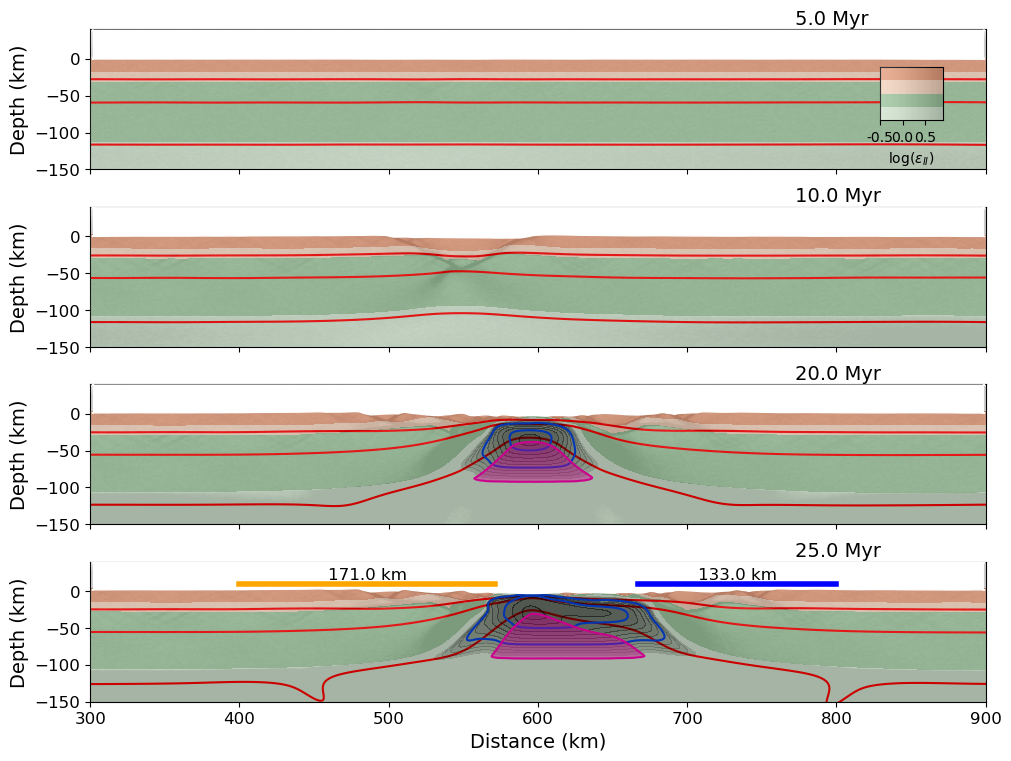

In [7]:
##############################################################################################################
#Set mandyoc property

# prop = 'density'
# prop = 'heat'
prop = 'lithology'
# prop = 'pressure'
# prop = 'strain'
# prop = 'strain_rate'
# prop = 'temperature'
# prop = 'temperature_anomaly'
# prop = 'viscosity'
# prop = 'surface'

##############################################################################################################
#Set instants
if(prop != 'surface'):
    instants = [5, 10, 20, 25] #Myr
    # instants = [5, 10, 15, 30] #Myr
else:
    instants = [10, 20, 30, 40] #Myr

##############################################################################################################
#Creating figure and subplots
plt.close()
# gridspec_kw={'height_ratios':[0.3,0.5]}

if(len(instants) > 1):
    fig_height = (3.0/2.0)*(len(instants) + 1) #6 minimum
#     fig_height = (2.0)*(len(instants) + 1) #4 is minimum

    fig, ax = plt.subplots(len(instants), 1, constrained_layout=True, figsize=(10, fig_height), sharex=False, sharey=True)
else:
    fig, ax = plt.subplots(len(instants), 1, constrained_layout=True, figsize=(12,4), sharex=False, sharey=True)
ax = ax.flatten() #flatten the ax array to make it easier to iterate over the subplots

alphabet = list(string.ascii_lowercase)
letters = alphabet[0: len(instants)]

i = 0
zoom_uc = True
# zoom_uc = False

Lcraton = 0 
# Lcraton = 1200.0

if(prop != 'surface'): # you can customize
    if(zoom_uc):
        xlims = xlims = [300, 900]
        ylims = [-150, 40]
        # plot steps
        plot_particles = True
    else:
        xlims = [0, float(dataset.isel(time=i).lx) / 1.0e3]
        ylims = [-float(dataset.isel(time=i).lz) / 1.0e3 + 40, 40]
        # plot steps
        plot_particles = False
        print(xlims, ylims)
else: #for surface plot
    if(zoom_uc):
        xlims = [0, float(dataset.isel(time=i).lx)/1.0e3]
        ylims = [-1.0, 1.0]
        
    else:
        xmin = 0 #+ 200
        xmax = float(dataset.isel(time=i).lx) / 1.0E3 #- 200
        xlims = [xmin, xmax]
        ylims = [-1.0, 1.0]
        # ylims = [-5, 5]

for instant, i in zip(instants, range(len(instants))):
    idx = find_nearest(dataset.time, instant)
    if(instant == instants[0]):
        plot_colorbar = True
    else:
        plot_colorbar = False
        
    plot_particles = True
    plot_property(dataset.isel(time=idx), prop, xlims, ylims, scenario,
             fig,
             ax[i],
             plot_isotherms = plot_isotherms,
             plot_particles = False,
             particle_size = 0.2,
             particle_marker = ".",
             ncores = 20,
            #  step_plot = 4,
             isotherms = [500, 800, 1300],
             plot_colorbar=plot_colorbar,
             bbox_to_anchor=(0.89,#horizontal position respective to parent_bbox or "loc" position
                            0.3,# vertical position
                            0.07,# width
                            0.38),# height
             plot_melt = plot_melt,
             # melt_method = melt_method,
            )
    
    if(instant == instants[-1]):
        calc_margin_width = True
    else:
        calc_margin_width = False
        
    if(calc_margin_width == True): #Measuring margin width
        xl_begin = 400
        xl_end = 620

        xr_begin = 620
        xr_end = 800

        marginl_begin, marginl_end, marginl_len, marginr_begin, marginr_end, marginr_len = measure_margins_width(dataset.isel(time=idx), xl_begin, xl_end, xr_begin, xr_end)

        ax[i].plot([marginl_begin, marginl_end], [10,10], color='orange', linestyle='-', linewidth=4.0, zorder=52)
        ax[i].text(marginl_begin + marginl_len/2, 12, f'{str(round(marginl_len, 2))} km', fontsize=12, ha='center', va='bottom', zorder=52)

        ax[i].plot([marginr_begin, marginr_end], [10, 10], color='blue', linestyle='-', linewidth=4.0, zorder=52)
        ax[i].text(marginr_begin - marginr_len/2, 12, f'{str(round(marginr_len, 2))} km', fontsize=12, ha='center', va='bottom', zorder=52)
    
label_fsize = 14
for i in range(len(instants)):
    ax[i].set_ylabel('Depth (km)', fontsize=label_fsize)

    if(i == len(instants) - 1):
        ax[i].set_xlabel('Distance (km)', fontsize=label_fsize)
    else:
        ax[i].set_xticklabels([])

figname = f"{scenario.split('/')[-1]}_steps"
print(f"Saving figure: {figname}")
fig.savefig(f"{scenario}/_output/{figname}.pdf", dpi=300)
fig.savefig(f"{scenario}/_output/{figname}.png", dpi=300)

0.0